In [31]:
# Fix imports when running from notebooks/ folder
import sys
from pathlib import Path

project_root = Path.cwd().parent 
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Added to path: {project_root}")

%load_ext autoreload
%autoreload 2

Added to path: /Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import src.data.loader as loader
import src.modeling.pipeline as modeling_pipeline 
import src.training.train_model as model_trainer
from scripts.constants import (
    CLEAN_FRAUD_DATA_FILE_NAME,
    CLEAN_DATA_DIR,
    Fraud_Data_Columns,
    FRAUD_DATA_NUMERIC_COLS,
    Model_Names
)
from tabulate import tabulate
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [33]:
data_loader = loader.DataLoader()
fraud_df = data_loader.load_csv(
    file_name=CLEAN_FRAUD_DATA_FILE_NAME, file_path=CLEAN_DATA_DIR, should_parse_dates=True
)

Loaded ../data/processed/fraud_data_clean.csv to dataframe!


## Fraud Data Modeling

In [34]:
fraud_df.info()
print(tabulate(fraud_df.tail(), headers="keys", tablefmt="grid"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            151112 non-null  int64         
 1   signup_time        151112 non-null  datetime64[ns]
 2   purchase_time      151112 non-null  datetime64[ns]
 3   purchase_value     151112 non-null  int64         
 4   device_id          151112 non-null  object        
 5   source             151112 non-null  object        
 6   browser            151112 non-null  object        
 7   sex                151112 non-null  object        
 8   age                151112 non-null  int64         
 9   ip_address         151112 non-null  float64       
 10  class              151112 non-null  int64         
 11  ip_int             151112 non-null  int64         
 12  country            151112 non-null  object        
 13  hour_of_day        151112 non-null  int64   

In [35]:
# Train Test Split
y = fraud_df[Fraud_Data_Columns.CLASS.value]
X = fraud_df.drop(columns=[Fraud_Data_Columns.CLASS.value])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

In [36]:
# Data Transformation
data_transformer = modeling_pipeline.DataTransformer()
X_train_transformed = data_transformer.fit_transform(X_train)
X_test_transformed = data_transformer.transform(X_test)

In [37]:
# Handle Imbalance
imbalance_handler = modeling_pipeline.ImbalanceHandler()
X_train_bal, y_train_bal = imbalance_handler.fit_resample(X_train_transformed, y_train)

In [38]:
# Inspect Results

num_features = data_transformer.numeric_cols
categorical_features = data_transformer.preprocessor.named_transformers_[
    "cat"
].get_feature_names_out(data_transformer.categorical_cols)

feature_names = list(num_features) + list(categorical_features)


In [39]:
# Transformed Data
X_train_dense = X_train_transformed.toarray()
X_train_df = pd.DataFrame(X_train_dense, columns=feature_names, index=X_train.index)
print(
    tabulate(
        X_train_df[FRAUD_DATA_NUMERIC_COLS].head(), headers="keys", tablefmt="grid"
    )
)

+--------+------------------+------------+
|        |   purchase_value |        age |
+========+==================+============+
|  61026 |        -0.813711 | -0.481402  |
+--------+------------------+------------+
| 141753 |        -0.868304 |  2.30576   |
+--------+------------------+------------+
|  84396 |        -1.41424  | -1.41046   |
+--------+------------------+------------+
| 115715 |         1.80678  | -0.0168755 |
+--------+------------------+------------+
|  61833 |         0.387348 | -0.481402  |
+--------+------------------+------------+


In [40]:
print(y_train_bal.value_counts())

class
0    95872
1    33555
Name: count, dtype: int64


Inspect Balanced Data:


<Axes: xlabel='class', ylabel='count'>

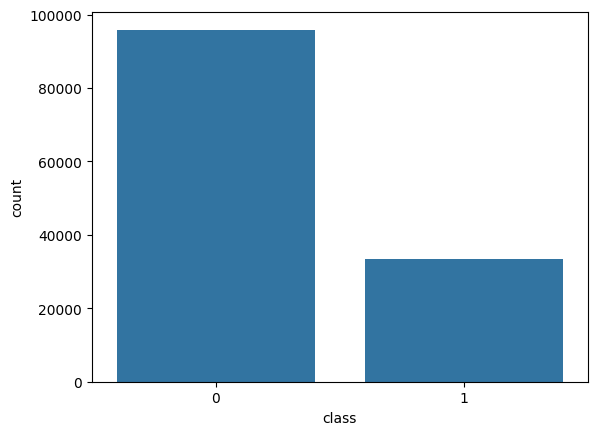

In [41]:
print("Inspect Balanced Data:")
sns.countplot(x=y_train_bal)

In [42]:
trainer = model_trainer.TrainModel(
    X_train=X_train_bal, X_test=X_test_transformed, y_train=y_train_bal, y_test=y_test
)


### Train & Evaluate Baseline Logistic Regression Model

In [43]:
trainer.train_model(model_name=Model_Names.LOGISTIC_REGRESSION.value)
trainer.evaluate_model()

Training Logistic Regression...
Training Logistic Regression complete!
Confusion Matrix
: [[40766   323]
 [ 1960  2285]]
F1-Score 0.6668612286589815
AUC-PR 0.5832494585665274


{'confusion_matrix': array([[40766,   323],
        [ 1960,  2285]]),
 'fl_score': 0.6668612286589815,
 'auc_pr': 0.5832494585665274}

### Train & Evaluate Ensemble Random Forest Model with Hyperparameter Tuning

In [44]:
trainer.train_model(model_name=Model_Names.RANDOM_FOREST.value, class_weight='balanced', n_estimators=200, max_depth=20)
trainer.evaluate_model()

Training Random Forest...
Training Random Forest complete!
Confusion Matrix
: [[40896   193]
 [ 2520  1725]]
F1-Score 0.5597923089404511
AUC-PR 0.5135107344416948


{'confusion_matrix': array([[40896,   193],
        [ 2520,  1725]]),
 'fl_score': 0.5597923089404511,
 'auc_pr': 0.5135107344416948}

### Train & Evaluate Ensemble XGBoost Model with Hyperparameter Tuning

In [45]:
trainer.train_model(
    model_name=Model_Names.XGBoost.value,
    n_estimators=200,
    max_depth=7,
)
trainer.evaluate_model()

Training XGBoost...
Training XGBoost complete!
Confusion Matrix
: [[40920   169]
 [ 2732  1513]]
F1-Score 0.5105449637253248
AUC-PR 0.5344530193048196


{'confusion_matrix': array([[40920,   169],
        [ 2732,  1513]]),
 'fl_score': 0.5105449637253248,
 'auc_pr': 0.5344530193048196}

In [49]:
# Only pass tree-specific params to tree models
tree_params = {"n_estimators": 200, "max_depth": 20}

results = []
for model_name in [
    Model_Names.LOGISTIC_REGRESSION.value,
    Model_Names.RANDOM_FOREST.value,
    Model_Names.XGBoost.value,
]:
    if model_name == Model_Names.LOGISTIC_REGRESSION.value:
        res = trainer.cross_val_evaluate(model_name=model_name)
    else:
        res = trainer.cross_val_evaluate(model_name=model_name, **tree_params)
    results.append(res)

/Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/elshaday/DEV/10Academy/fraud-detection-week-5-and-6/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale

Logistic Regression CV Results:
F1-Score: 0.777 ± 0.004
AUC-PR : 0.963 ± 0.002
Random Forest CV Results:
F1-Score: 0.000 ± 0.000
AUC-PR : 0.796 ± 0.006
XGBoost CV Results:
F1-Score: 0.785 ± 0.007
AUC-PR : 0.865 ± 0.017


| Model               | F1-score (mean ± std) | AUC-PR (mean ± std) |
| ------------------- | --------------------- | ------------------- |
| Logistic Regression | 0.777 ± 0.004         | 0.963 ± 0.002       |
| Random Forest       | 0.000 ± 0.000         | 0.796 ± 0.006       |
| XGBoost             | 0.785 ± 0.007         | 0.865 ± 0.017       |


### Analysis

#### F1-Score

- XGBoost: 0.785 (slightly higher than LR 0.777) → better balance between precision and recall.

- Random Forest: 0.0 → model is completely failing to detect the minority class (probably due to imbalance handling).

#### AUC-PR

- Logistic Regression: 0.963 → excellent precision-recall performance.

- XGBoost: 0.865 → good, but lower than LR.

#### Stability

- Both LR and XGBoost have low std, so they are consistent across folds.


### Interpretation & Recommendation

- Random Forest is clearly not performing well, likely needs better class weighting or SMOTE adjustment.

- Logistic Regression vs XGBoost:

    - LR: slightly lower F1 but much higher AUC-PR → better at separating fraud vs non-fraud.

    - XGBoost: slightly better F1 but lower AUC-PR → might detect slightly more fraud, but more false positives.

- Interpretability: LR is simpler to explain to stakeholders; XGBoost is more complex.

### Best choice:

Maximizing PR-AUC and interpretability matters → Logistic Regression.

